# Table of Contents
 <p><div class="lev1"><a href="#Scraping-the-Data"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scraping the Data</a></div><div class="lev2"><a href="#Scraping-the-Column-Headers"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Scraping the Column Headers</a></div><div class="lev2"><a href="#Scraping-the-Data"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Scraping the Data</a></div><div class="lev2"><a href="#Scraping-the-data-for-all-seasons-since-1967"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Scraping the data for all seasons since 1967</a></div><div class="lev1"><a href="#Cleaning-the-Data"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cleaning the Data</a></div><div class="lev2"><a href="#Create-a-Player-ID/Links-DataFrame"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create a Player ID/Links <code>DataFrame</code></a></div><div class="lev2"><a href="#Cleaning-up-the-rest-of-the-draft-data."><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Cleaning up the rest of the draft data.</a></div><div class="lev1"><a href="#Exploring-the-NFL-Draft"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploring the NFL Draft</a></div><div class="lev2"><a href="#The-Career-Approximate-Value-distribution-for-each-position"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>The Career Approximate Value distribution for each position</a></div><div class="lev2"><a href="#Approximate-Value-by-draft-pick"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Approximate Value by draft pick</a></div>

After reading a [couple](https://statsbylopez.com/2016/05/02/the-nfl-draft-where-we-stand-in-2016/) of [posts](https://statsbylopez.com/2016/05/04/approximate-value-and-the-nfl-draft/) by [Michael Lopez](https://twitter.com/StatsbyLopez), I decided to recreate his analyis using Python instead of R.

First up lets import most of the stuff we will be using.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *

import numpy as np
import pandas as pd

from urllib.request import urlopen
from bs4 import BeautifulSoup

# Scraping the Data



Before we can do anything we will need some data.  We'll be scraping draft data from [Pro-Football-Reference](http://www.pro-football-reference.com/) and then clean it up for the analysis.

To scrape the data we will be using `BeautifulSoup` and storing the data into a `pandas` `Dataframe`.

To get a feel of the data we will be scraping let take a look at the [1967 draft](http://www.pro-football-reference.com/years/1967/draft.htm).  

<img  src="Selection_001.png"/>

Above is just a small part of the draft table found on the web page.  We will extract the second row of column headers and all that information for each pick.  While we we are at it, we will also scrape each player's Pro-Football-Reference player page link and college stats link.  This way if we ever want to scrape data from their player page in the future, we can. 

In [2]:
# The url we will be scraping
url_1967 = "http://www.pro-football-reference.com/years/1967/draft.htm"

# get the html
html = urlopen(url_1967)

# create the BeautifulSoup object
soup = BeautifulSoup(html, "lxml")

## Scraping the Column Headers

The column headers we will scrape are found in the second row of column headers.  We will also add two additional columns headers for the two additional links we will be scraping.

In [3]:
# Extract the necessary values for the column headers from the table
# and store them as a list
column_headers = [th.getText() for th in 
                  soup.findAll('tr', limit=2)[1].findAll('th')]

# Add the two additional column headers for the player links
column_headers.extend(["Player_NFL_Link", "Player_NCAA_Link"])

## Scraping the Data

We can easily extract the rows of data using the [CSS selector](http://www.w3schools.com/cssref/css_selectors.asp) "#draft tr".  What we are essentially doing is selecting table row elements within the element that has the id of "draft".  A really helpful tool when it comes to finding CSS selectors is [SelectorFadget](http://selectorgadget.com/).  It's a web extension that lets you click on different elements of a web page and provides the CSS selector for those selected elements.

In [4]:
# The data is found within the table rows of the element with id=draft
# We want the elements from the 3rd row and on
table_rows = soup.select("#drafts tr")[2:] 

`table_rows` is a list of tag elements.

In [5]:
type(table_rows)

list

In [6]:
type(table_rows[0])

bs4.element.Tag

In [7]:
table_rows[0] # take a look at the first row

<tr class="">
<td align="right">1</td>
<td align="right" csk="0.5">1</td>
<td align="left" csk="clt01"><a href="/teams/clt/1967_draft.htm" title="Baltimore Colts">BAL</a></td>
<td align="left" csk="Smith,Bubba"><a href="/players/S/SmitBu00.htm">Bubba Smith</a></td>
<td align="left" csk="DE--------0001">DE</td>
<td align="right">22</td>
<td align="right">1976</td>
<td align="right">1</td>
<td align="right">2</td>
<td align="right">6</td>
<td align="right">62</td>
<td align="right">46</td>
<td align="right">111</td>
<td align="right"></td>
<td align="right"></td>
<td align="right"></td>
<td align="right"></td>
<td align="right"></td>
<td align="right"></td>
<td align="right"></td>
<td align="right"></td>
<td align="right"></td>
<td align="right"></td>
<td align="right"></td>
<td align="right"></td>
<td align="right"></td>
<td align="left"><a href="/schools/michiganst/">Michigan St.</a></td>
<td align=""><a href="http://www.sports-reference.com/cfb/players/bubba-smith-2.html">College Stat

The data we want for each player is found within the the `td` (or table data) elements.  

Below I've created a function that extracts the data we want from `table_rows`.  The comments should walk you through what each part of the function does.

In [8]:
def extract_player_data(table_rows):
    """
    Extract and return the the desired information from the td elements within
    the table rows.
    """
    # create the empty list to store the player data
    player_data = []
    
    for row in table_rows:  # for each row do the following

        # Get the text for each table data (td) element in the row
        # Some player names end with ' HOF', if they do, strip that part away,
        # otherwise get all the text data from the table data
        player_list = [td.get_text()[:-4] if td.get_text().endswith(" HOF") 
                       else td.get_text() for td in row.find_all("td")]

        # there are some empty table rows, which are the repeated 
        # column headers in the table
        # we skip over those rows and and continue the for loop
        if not player_list:
            continue

        # Extracting the player links
        # Instead of a list we create a dictionary, this way we can easily
        # match the player name with their pfr url
        # For all "a" elements in the row, get the text
        # NOTE: Same " HOF" text issue as the player_list above
        links_dict = {(link.get_text()[:-4]   # strip the last 4 characters
                       if link.get_text().endswith(" HOF")  # if they are " HOF"
                       # else get all text, set thet as the dictionary key 
                       # and set the url as the value
                       else link.get_text()) : link["href"] 
                       for link in row.find_all("a", href=True)}

        # The data we want from the dictionary can be extracted using the
        # player's name, which returns us their pfr url, and "College Stats"
        # which returns us their college stats page
    
        # add the link associated to the player's pro-football-reference page, 
        # or en empty string if there is no link
        player_list.append(links_dict.get(player_list[3], ""))

        # add the link for the player's college stats or an empty string
        # if ther is no link
        player_list.append(links_dict.get("College Stats", ""))

        # Now append the data to list of data
        player_data.append(player_list)
        
    return player_data

Now create a `DataFrame` with the data from the 1967 draft.

In [9]:
data = extract_player_data(table_rows)

df_1967 = pd.DataFrame(data, columns=column_headers)

In [10]:
df_1967.head()

,Rnd,Pick,Tm,,Pos,Age,To,AP1,PB,St,...,TD,Rec,Yds,TD,Int,Sk,College/Univ,,Player_NFL_Link,Player_NCAA_Link
0,1,1,BAL,Bubba Smith,DE,22,1976,1,2,6,...,,,,,,,Michigan St.,College Stats,/players/S/SmitBu00.htm,http://www.sports-reference.com/cfb/players/bu...
1,1,2,MIN,Clint Jones,RB,22,1973,0,0,2,...,20,38,431,0,,,Michigan St.,College Stats,/players/J/JoneCl00.htm,http://www.sports-reference.com/cfb/players/cl...
2,1,3,SFO,Steve Spurrier,QB,22,1976,0,0,6,...,2,,,,,,Florida,College Stats,/players/S/SpurSt00.htm,http://www.sports-reference.com/cfb/players/st...
3,1,4,MIA,Bob Griese,QB,22,1980,2,8,12,...,7,,,,,,Purdue,College Stats,/players/G/GrieBo00.htm,http://www.sports-reference.com/cfb/players/bo...
4,1,5,HOU,George Webster,LB,21,1976,3,3,6,...,,,,,5,,Michigan St.,College Stats,/players/W/WebsGe00.htm,http://www.sports-reference.com/cfb/players/ge...


## Scraping the data for all seasons since 1967

Scraping the for all drafts since 1967 follows as a similar process as above, just repeated for each draft year, using a `for` loop.

As we loop over the years, we will create a `DataFrame` for each draft, and append it to a large list of `DataFrame`s.  We will also have a separate list that will contain any errors and the url associated with that error.  This will let us know if there are any issues with our scraper, and which url is causing the error. We will also have to add an additional column for tackles.  Tackles show up after the 1993 season, so that is a column we need to insert into the `DataFrame`s we create for the drafts from 1967 to 1993.

In [11]:
# Create an empty list that will contain all the dataframes
# (one dataframe for each draft)
draft_dfs_list = []

# a list to store any errors that may come up while scraping
errors_list = []

In [12]:
# The url template that we pass in the draft year inro
url_template = "http://www.pro-football-reference.com/years/{year}/draft.htm"

# for each year from 1967 to (and including) 2016
for year in range(1967, 2017): 
    
    # Use try/except block to catch and inspect any urls that cause an error
    try:
        # get the draft url
        url = url_template.format(year=year)

        # get the html
        html = urlopen(url)

        # create the BeautifulSoup object
        soup = BeautifulSoup(html, "lxml") 

        # get the column headers
        column_headers = [th.getText() for th in 
                          soup.findAll('tr', limit=2)[1].findAll('th')]
        column_headers.extend(["Player_NFL_Link", "Player_NCAA_Link"])

        # select the data from the table using the '#drafts tr' CSS selector
        table_rows = soup.select("#drafts tr")[2:] 

        # extract the player data from the table rows
        player_data = extract_player_data(table_rows)

        # create the dataframe for the current years draft
        year_df = pd.DataFrame(player_data, columns=column_headers)

        # if it is a draft from before 1994 then add a Tkl column at the 
        # 24th position
        if year < 1994:
            year_df.insert(24, "Tkl", "")

        # add the year of the draft to the dataframe
        year_df.insert(0, "Draft_Yr", year)

        # append the current dataframe to the list of dataframes
        draft_dfs_list.append(year_df)
    
    except Exception as e:
        # Store the url and the error it causes in a list
        error =[url, e] 
        # then append it to the list of errors
        errors_list.append(error)

In [13]:
len(errors_list)

0

In [14]:
errors_list

[]

Well, we don't get any errors, so that's good.

Now we can concatenate all the `DataFrame`s we scraped and create one large `DataFrame`.

In [15]:
draft_df = pd.concat(draft_dfs_list, ignore_index=True)

In [16]:
draft_df.head()

,Draft_Yr,Rnd,Pick,Tm,,Pos,Age,To,AP1,PB,...,Rec,Yds,TD,Tkl,Int,Sk,College/Univ,,Player_NFL_Link,Player_NCAA_Link
0,1967,1,1,BAL,Bubba Smith,DE,22,1976,1,2,...,,,,,,,Michigan St.,College Stats,/players/S/SmitBu00.htm,http://www.sports-reference.com/cfb/players/bu...
1,1967,1,2,MIN,Clint Jones,RB,22,1973,0,0,...,38,431,0,,,,Michigan St.,College Stats,/players/J/JoneCl00.htm,http://www.sports-reference.com/cfb/players/cl...
2,1967,1,3,SFO,Steve Spurrier,QB,22,1976,0,0,...,,,,,,,Florida,College Stats,/players/S/SpurSt00.htm,http://www.sports-reference.com/cfb/players/st...
3,1967,1,4,MIA,Bob Griese,QB,22,1980,2,8,...,,,,,,,Purdue,College Stats,/players/G/GrieBo00.htm,http://www.sports-reference.com/cfb/players/bo...
4,1967,1,5,HOU,George Webster,LB,21,1976,3,3,...,,,,,5,,Michigan St.,College Stats,/players/W/WebsGe00.htm,http://www.sports-reference.com/cfb/players/ge...


We should edit the columns a bit as there are some repeated column headers and some are even empty strings.

In [17]:
# get the current column headers from the dataframe as a list
column_headers = draft_df.columns.tolist()

# The 5th column header is an empty string, but represesents player names
column_headers[4] = "Player"

# Prepend "Rush_" for the columns that represent rushing stats 
column_headers[19:22] = ["Rush_" + col for col in column_headers[19:22]]

# Prepend "Rec_" for the columns that reperesent receiving stats
column_headers[23:25] = ["Rec_" + col for col in column_headers[23:25]]

# Properly label the defensive int column as "Def_Int"
column_headers[-6] = "Def_Int"

# Just use "College" as the column header represent player's colleger or univ
column_headers[-4] = "College"

# Take a look at the updated column headers
column_headers

['Draft_Yr',
 'Rnd',
 'Pick',
 'Tm',
 'Player',
 'Pos',
 'Age',
 'To',
 'AP1',
 'PB',
 'St',
 'CarAV',
 'DrAV',
 'G',
 'Cmp',
 'Att',
 'Yds',
 'TD',
 'Int',
 'Rush_Att',
 'Rush_Yds',
 'Rush_TD',
 'Rec',
 'Rec_Yds',
 'Rec_TD',
 'Tkl',
 'Def_Int',
 'Sk',
 'College',
 '',
 'Player_NFL_Link',
 'Player_NCAA_Link']

In [18]:
# Now assign edited columns to the DataFrame
draft_df.columns = column_headers

Now that we fixed up the necessary columns, let's write out the raw data to a CSV file.

In [19]:
# Write out the raw draft data to the raw_data fold in the data folder
draft_df.to_csv("data/raw_data/pfr_nfl_draft_data_RAW.csv", index=False)

# Cleaning the Data

Now that we have all the raw we want, we need to clean it up a bit in order to do some of the analysis we want.  

## Create a Player ID/Links `DataFrame` 

First lets create a separate `DataFrame` that contains just the player names, their player page links, and the player ID on Pro-Football-Reference.  This way we can have a separate CSV file that just contains the necessary information to extract individual player data sometime in the future.

To extract the Pro-Football-Reference player ID from the player link, we will need to use a [regular expression](https://en.wikipedia.org/wiki/Regular_expression). The ID is found between the third slash (`'/'`) and the period (`'.'`) before "htm". The regular expression that we can use to match that pattern of the player link and extract the ID is as follows:

    /.*/.*/(.*)\.
    
What the above regular expression essentially says is match the string with the following pattern:
- One `'/'`. 
- Followed by 0 or more characters (this is represented by the `'.*'` characters).
- Followed by another `'/'` (the 2nd `'/'` character).
- Followed by 0 or more characters (again the `'.*'` characters) .
- Followed by another (3rd) `'/'`.
- Followed by a grouping of 0 or more characters (the `'(.*)'` characters).
  - This is the key part of our regular expression. The `'()'` characters create a grouping around the characters we want to extract.  Since the player IDs are found between the 3rd `'/'` and the `'.'`, we use `'(.*)'` to extract all the characters found in that part of our string.
- Followed by a `'.'`.

We can extract the IDs by passing the above regular expression into the `pandas extract` method.

In [20]:
# extract the player id from the player links, expand=False returns the 
# IDs as a pandas Series
player_ids = draft_df.Player_NFL_Link.str.extract("/.*/.*/(.*)\.", 
                                                  expand=False)

In [21]:
# add a Player_ID column to our draft_df
draft_df["Player_ID"] = player_ids

In [22]:
# add the beginning of the pfr url to the player link column
pfr_url = "http://www.pro-football-reference.com"
draft_df.Player_NFL_Link =  pfr_url + draft_df.Player_NFL_Link

Now we can save a `DataFrame` just containing the player names, IDs, and links.

In [23]:
# Get the Player name, IDs, and links
player_id_df = draft_df.loc[:, ["Player", "Player_ID", "Player_NFL_Link", 
                                "Player_NCAA_Link"]]
# Save them to a CSV file
player_id_df.to_csv("data/clean_data/pfr_player_ids_and_links.csv",
                    index=False)

## Cleaning up the rest of the draft data.

Now that we are done with the play ID stuff lets get back to dealing with the draft data.

Lets first drop some unnecessary columns.

In [24]:
# drop the the player links and the column labeled by an empty string
draft_df.drop(draft_df.columns[-4:-1], axis=1, inplace=True)

The main issue left with the rest of the draft data is converting everything to their proper data type.

In [25]:
draft_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15845 entries, 0 to 15844
Data columns (total 30 columns):
Draft_Yr     15845 non-null int64
Rnd          15845 non-null object
Pick         15845 non-null object
Tm           15845 non-null object
Player       15845 non-null object
Pos          15845 non-null object
Age          15845 non-null object
To           15845 non-null object
AP1          15845 non-null object
PB           15845 non-null object
St           15845 non-null object
CarAV        15845 non-null object
DrAV         15845 non-null object
G            15845 non-null object
Cmp          15845 non-null object
Att          15845 non-null object
Yds          15845 non-null object
TD           15845 non-null object
Int          15845 non-null object
Rush_Att     15845 non-null object
Rush_Yds     15845 non-null object
Rush_TD      15845 non-null object
Rec          15845 non-null object
Rec_Yds      15845 non-null object
Rec_TD       15845 non-null object
Tkl          1584

From the above we can see that a lot of the player data isn't numeric when it should be.  To convert all the columns to their proper numeric type we can apply the `to_numeric` function to the whole `DataFrame`.  Also note that it is impossible to convert some of the columns into a numeric type (since they aren't numbers) so we need to set the `errors` parameter to "ignore" to avoid raising any errors.

In [26]:
# convert the data to proper numeric types
draft_df = draft_df.apply(pd.to_numeric, errors="ignore")

In [27]:
draft_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15845 entries, 0 to 15844
Data columns (total 30 columns):
Draft_Yr     15845 non-null int64
Rnd          15845 non-null int64
Pick         15845 non-null int64
Tm           15845 non-null object
Player       15845 non-null object
Pos          15845 non-null object
Age          11297 non-null float64
To           10995 non-null float64
AP1          15845 non-null int64
PB           15845 non-null int64
St           15845 non-null int64
CarAV        10995 non-null float64
DrAV         9571 non-null float64
G            10962 non-null float64
Cmp          1033 non-null float64
Att          1033 non-null float64
Yds          1033 non-null float64
TD           1033 non-null float64
Int          1033 non-null float64
Rush_Att     2776 non-null float64
Rush_Yds     2776 non-null float64
Rush_TD      2776 non-null float64
Rec          3395 non-null float64
Rec_Yds      3395 non-null float64
Rec_TD       3395 non-null float64
Tkl          3644 

We are not done yet. A lot of out numeric columns are missing data because players didn't accumulate any of those stats (e.g. some players didn't score a TD or even play a game).  Let's select the columns with numeric data and then replace the `NaN`s (the current value that represents data is missing) with 0s as that is a more appropriate value. 

In [28]:
# Get the column names for the numeric columns
num_cols = draft_df.columns[draft_df.dtypes != object]

# Replace all NaNs with 0
draft_df.loc[:, num_cols] = draft_df.loc[:, num_cols].fillna(0)

In [29]:
# Everything is filled, except for Player_ID, which is fine for now
draft_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15845 entries, 0 to 15844
Data columns (total 30 columns):
Draft_Yr     15845 non-null int64
Rnd          15845 non-null int64
Pick         15845 non-null int64
Tm           15845 non-null object
Player       15845 non-null object
Pos          15845 non-null object
Age          15845 non-null float64
To           15845 non-null float64
AP1          15845 non-null int64
PB           15845 non-null int64
St           15845 non-null int64
CarAV        15845 non-null float64
DrAV         15845 non-null float64
G            15845 non-null float64
Cmp          15845 non-null float64
Att          15845 non-null float64
Yds          15845 non-null float64
TD           15845 non-null float64
Int          15845 non-null float64
Rush_Att     15845 non-null float64
Rush_Yds     15845 non-null float64
Rush_TD      15845 non-null float64
Rec          15845 non-null float64
Rec_Yds      15845 non-null float64
Rec_TD       15845 non-null float64
Tkl   

We are finally done cleaning the data and now we can save it to a CSV file.

In [30]:
draft_df.to_csv("data/clean_data/pfr_nfl_draft_data_CLEAN.csv", index=False)

# Exploring the NFL Draft

Now that we are done getting and cleaning the data we want, we can finally have some fun.  First lets just keep the draft data up to and including the 2010 draft, as players who have been drafted more recently haven't accumulated enough career [Approximate Value](http://www.pro-football-reference.com/blog/?p=465) (or cAV).

In [31]:
# get data for drafts from 1967 to 2010
draft_df_2010 = draft_df.loc[draft_df.Draft_Yr <= 2010, :]

In [32]:
draft_df_2010.tail() # we see that the last draft is 2010

,Draft_Yr,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,...,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,Tkl,Def_Int,Sk,College,Player_ID
14314,2010,7,251,OAK,Stevie Brown,DB,23.0,2014.0,0,0,...,0.0,0.0,0.0,0.0,0.0,98.0,8.0,1.0,Michigan,BrowSt99
14315,2010,7,252,MIA,Austin Spitler,LB,23.0,2013.0,0,0,...,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,Ohio St.,SpitAu99
14316,2010,7,253,TAM,Erik Lorig,DE,23.0,2014.0,0,0,...,4.0,0.0,39.0,220.0,2.0,3.0,0.0,0.0,Stanford,LoriEr99
14317,2010,7,254,STL,Josh Hull,LB,23.0,2013.0,0,0,...,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,Penn St.,HullJo99
14318,2010,7,255,DET,Tim Toone,WR,25.0,2012.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Weber St.,ToonTi00


## The Career Approximate Value distribution for each position

We can visualize the 

In [44]:
# set some plotting styles
from matplotlib import rcParams

# set the plot size to 15x12
rcParams.update({"figure.figsize": (15,12)})

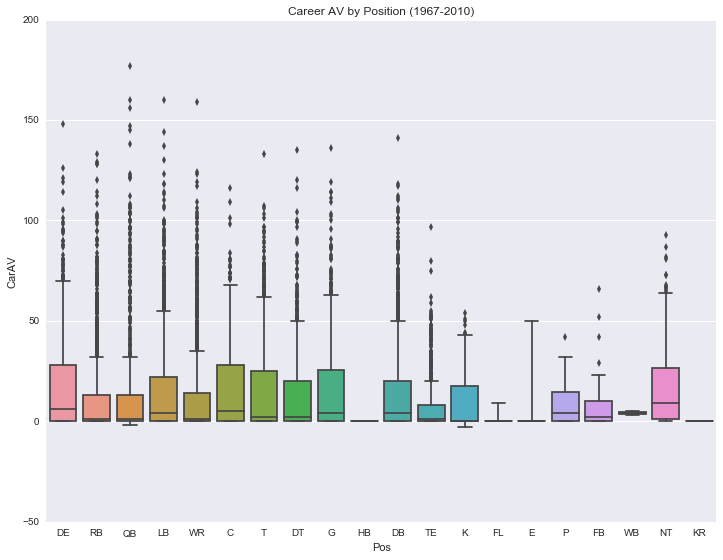

In [43]:
sns.boxplot(x="Pos", y="CarAV", data=draft_df_2010)
plt.title("Career AV by Position (1967-2010)")
plt.show()

In [ ]:
# Look at the counts for each position


## Approximate Value by draft pick

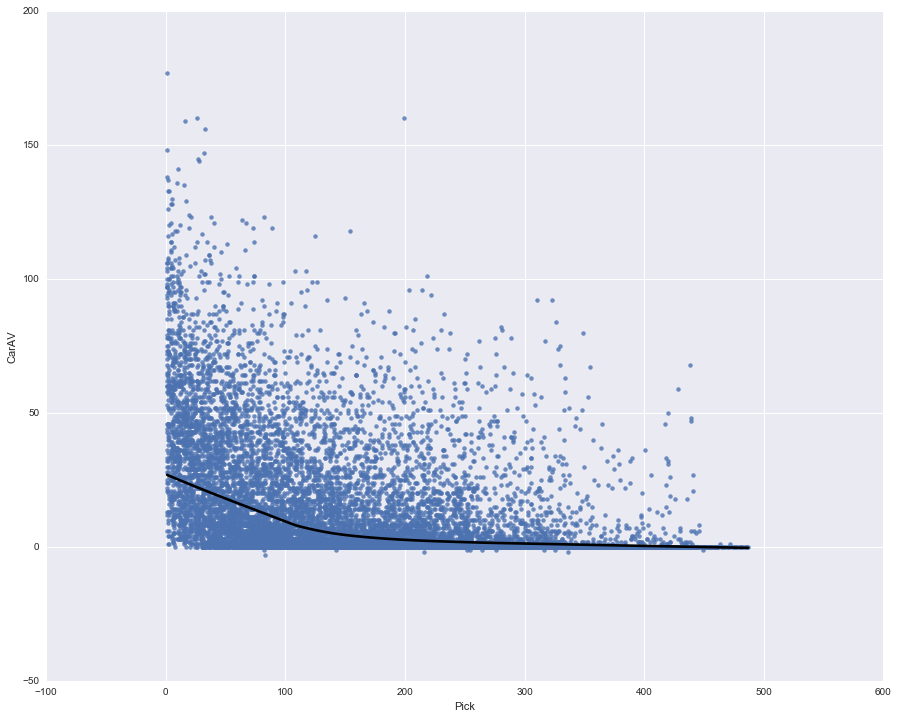

In [52]:
sns.regplot(draft_df_2010.Pick, draft_df_2010.CarAV, lowess=True,
            line_kws={"color": "black"})

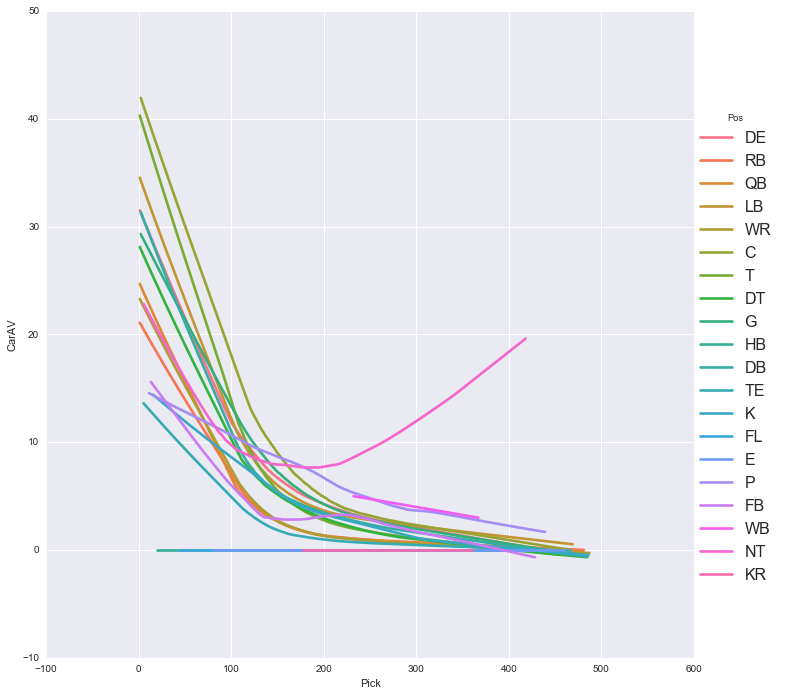

In [55]:
sns.lmplot(x="Pick", y="CarAV", data=draft_df_2010, lowess=True, hue="Pos",
          scatter=False, size=10)

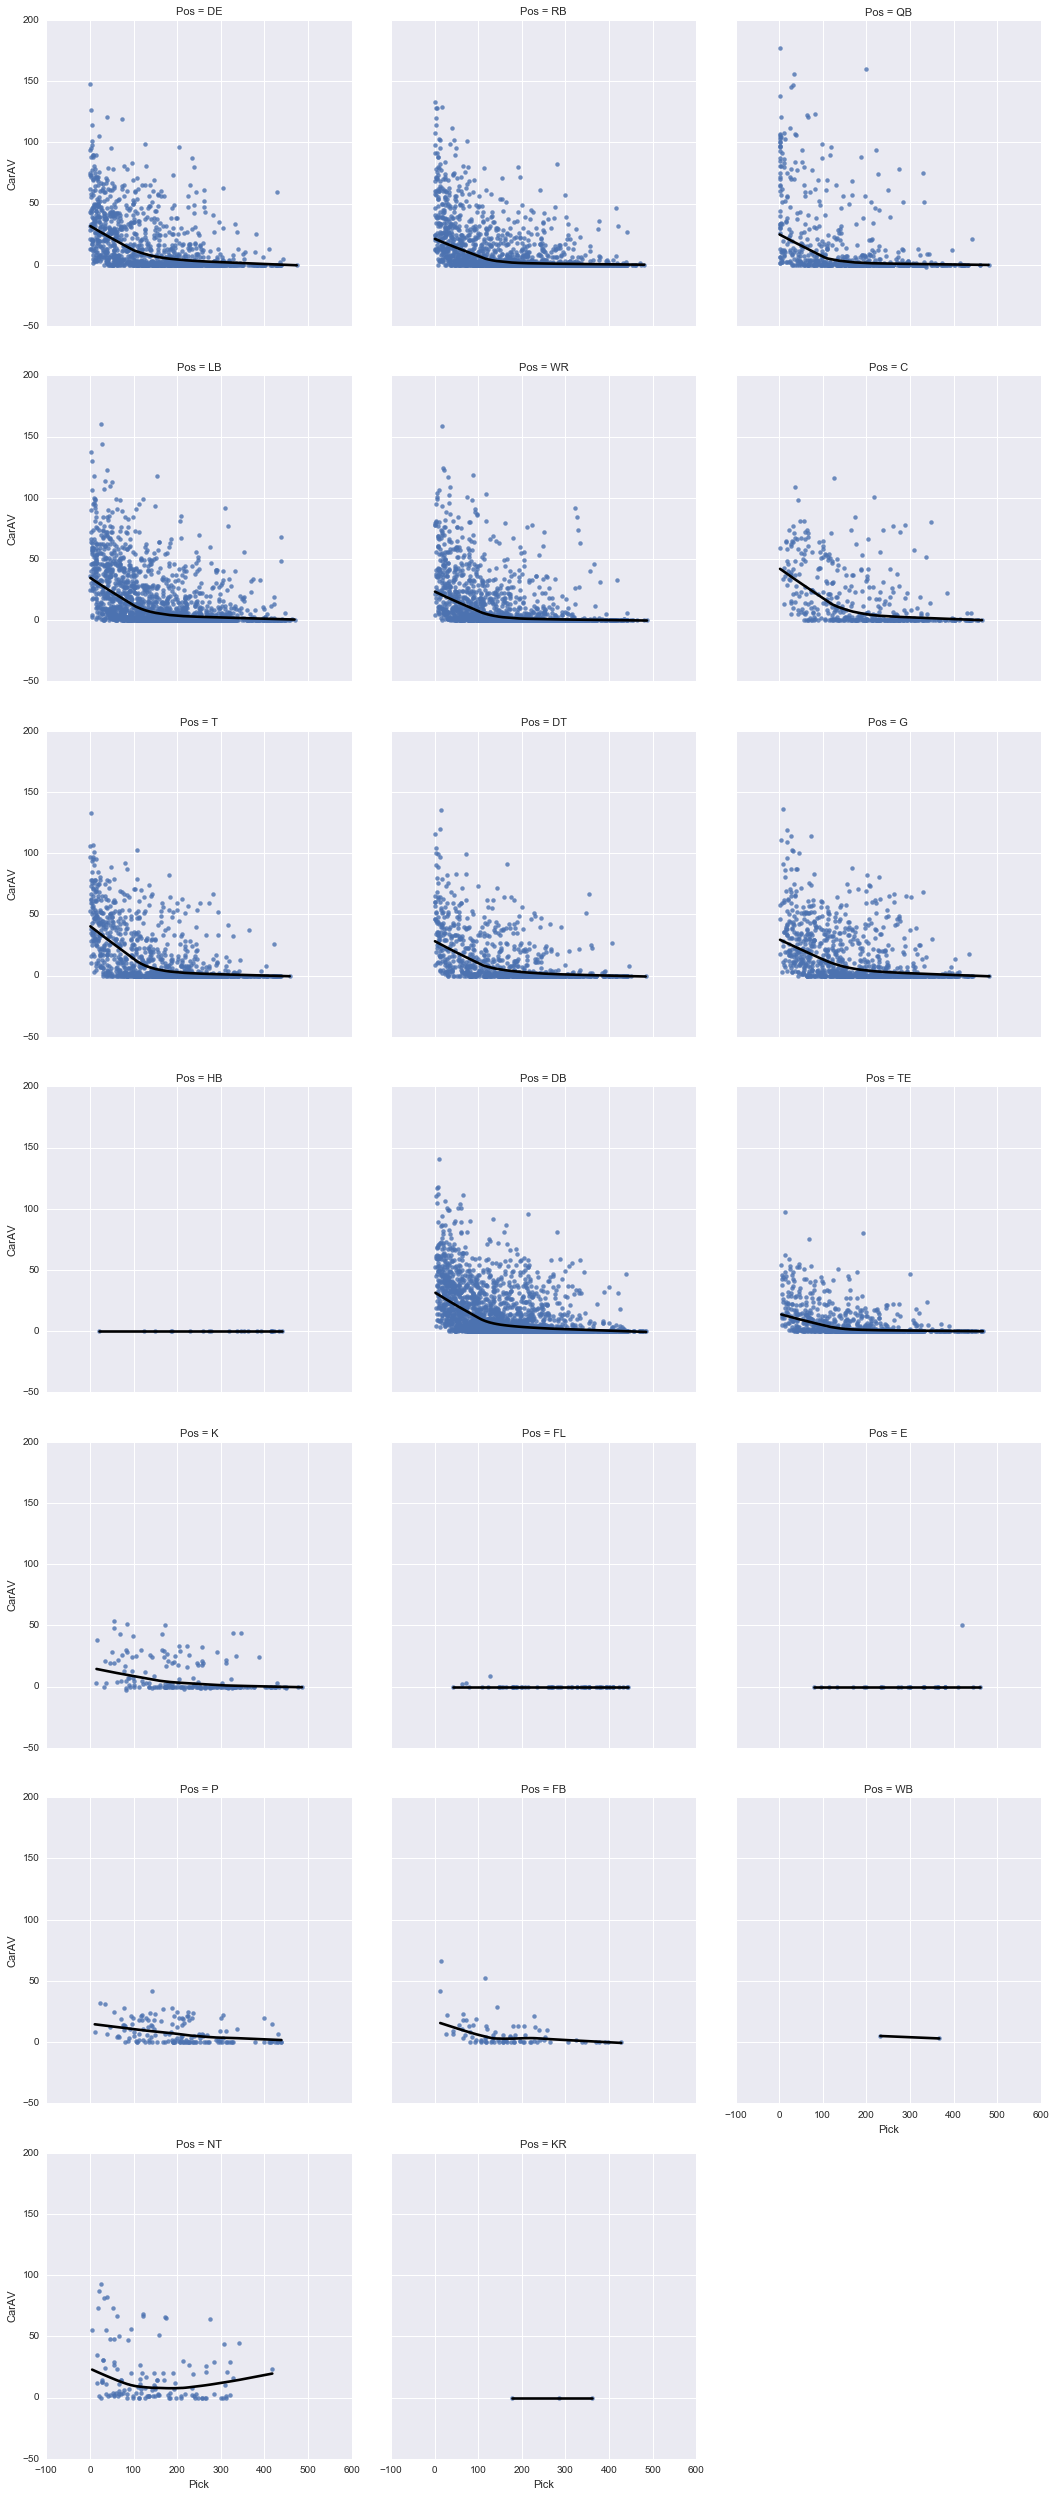

In [51]:
sns.lmplot(x="Pick", y="CarAV", data=draft_df_2010, lowess=True, col="Pos",
           line_kws={"color": "black"}, col_wrap=3, size=5)